In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

In [2]:
# Collect JSON data
main_dir = "../../../data/"
pos_dir = "english_netto_list/"
#neg_dir = "english_complement/"
neg_dir = "english_random_sample/"

def load_json(path):
    f = open(path+"/patent_info.json", 'r')
    data = json.load(f)
    f.close()
    return data

def collect_json(group_dir):
    path = main_dir + group_dir
    patent_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return [load_json(path+d) for d in patent_dirs]

pos_json = collect_json(pos_dir)
neg_json = collect_json(neg_dir)

In [2]:
## Same as above, but uses the zip archive instead
import zipfile

# Collect JSON data
main_dir = Path("F:/datasets/PRV_KEMI_DATA/packaged_patents")
pos_zip = main_dir / 'english_netto_list.zip'
#neg_dir = "english_complement/"
neg_zip = main_dir / 'english_random_sample.zip'

def collect_json(patent_archive):
    with zipfile.ZipFile(patent_archive) as pz:
        patent_infos = [zipinfo for zipinfo in pz.infolist() if 'patent_info.json' in zipinfo.filename]
        patent_info_data = []
        for zipinfo in tqdm(patent_infos, desc=f'Loading {patent_archive.name}'):
            with pz.open(zipinfo) as patent_info_fp:
                patent_info = json.load(patent_info_fp)
                patent_info_data.append(patent_info)
        return patent_info_data

pos_json = collect_json(pos_zip)
neg_json = collect_json(neg_zip)

Loading english_netto_list.zip:   0%|          | 0/7684 [00:00<?, ?it/s]

Loading english_random_sample.zip:   0%|          | 0/8331 [00:00<?, ?it/s]

In [3]:
# For testing
#pos_json = pos_json[:300]
#neg_json = neg_json[:300]

In [3]:
# Build corpus
def get_abstract(j): return [d["abstract"]["en"] for d in j]
def get_descriptions(j): return [d["description"]["en"] for d in j]
def get_claims(j): return [d["claims"]["en"] for d in j]

def make_tfidf_vectorizer(corpus):
    # Build TF-IDF vectors using default tokenizer while discarding non-alphabetic tokens
    min_count = 5
    max_freq = 0.2
    tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", 
                                    token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=min_count, max_df=max_freq)
    tfidf_vectorizer.fit(corpus)
    return tfidf_vectorizer

pos_abstracts = get_abstract(pos_json)
neg_abstracts = get_abstract(neg_json)
abstract_corpus =  pos_abstracts + neg_abstracts


pos_descriptions = get_descriptions(pos_json) 
neg_descriptions = get_descriptions(neg_json)
description_corpus = pos_descriptions + neg_descriptions

pos_claims = get_claims(pos_json) 
neg_claims = get_claims(neg_json)
claims_corpus = pos_claims + neg_claims

abstract_vectorizer = make_tfidf_vectorizer(abstract_corpus)
description_vectorizer = make_tfidf_vectorizer(description_corpus)
claims_vectorizer = make_tfidf_vectorizer(claims_corpus)


In [4]:
pos_vectors = [abstract_vectorizer.transform(pos_abstracts), description_vectorizer.transform(pos_descriptions), claims_vectorizer.transform(pos_claims)]

In [5]:
neg_vectors = [abstract_vectorizer.transform(neg_abstracts), description_vectorizer.transform(neg_descriptions), claims_vectorizer.transform(neg_claims)]

In [7]:
from scipy.sparse import hstack, vstack
stacked_pos_vectors = hstack(pos_vectors)
stacked_neg_vectors = hstack(neg_vectors)
vectors = vstack((stacked_pos_vectors, stacked_neg_vectors))
y = np.concatenate([np.ones(stacked_pos_vectors.shape[0]), np.zeros(stacked_neg_vectors.shape[0])])
    

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

In [14]:
classifier = RandomForestClassifier(n_estimators=100)
num_splits = 5
scores = cross_validate(classifier, vectors, y, cv=num_splits, scoring=["precision", "recall", "f1"])

In [15]:
scores

{'fit_time': array([59.29225206, 61.19333792, 51.25468969, 47.71900511, 41.05289245]),
 'score_time': array([0.44199967, 0.47411656, 0.4320004 , 0.40500045, 0.42000008]),
 'test_precision': array([0.90875689, 0.91377171, 0.89249249, 0.90324556, 0.91522277]),
 'test_recall': array([0.96551724, 0.95836044, 0.96681848, 0.95966168, 0.96289062]),
 'test_f1': array([0.9362776 , 0.93553509, 0.92816989, 0.93059937, 0.93845178])}

In [26]:
# Print examples from vocabulary
print(list(vocabulary[:10]))
print(list(vocabulary[-10:]))

['aa', 'ab', 'abbe', 'abc', 'abdominal', 'ability', 'ablation', 'able', 'abnormal', 'abnormality']
['zeolite', 'zero', 'zinc', 'zirconia', 'zirconium', 'zn', 'zno', 'zone', 'zones', 'zr']


In [27]:
# Print terms with highest tf-idf score per document
def top_tfidfs(v, k):
    return vocabulary[v.indices[np.argsort(v.data)[:-(k+1):-1]]]

for i in range(5):
    print(100 * '.')
    print(corpus[i][:400] + "...")
    print("Top tf-idf terms:", top_tfidfs(vectors[i], 5))

....................................................................................................
[0001] To provide a laminate comprising a pair of polycarbonate optical sheet or film which are laminated together through a polarizing film layer and an adhesive layer of a photochromic composition comprising (I) a polyurethane urea resin and (II) a photochromic compound and having excellent photochromic properties, adhesion, heat resistance, perspiration resistance and excellent adhesion to a le...
Top tf-idf terms: ['photochromic' 'adhesion' 'polarizing' 'film' 'resistance']
....................................................................................................
[0001] Disclosed is a film mirror for reflecting sunlight, which comprises, sequentially from the sunlight incident side, a polymer film base, a reflective layer that is configured of a silver coating, and a protective coating layer. The film mirror for reflecting sunlight is characterized in that the reflective l

In [139]:
# Embed vectors in two dimensions using t-SNE and scatter plot 

tsne_embedder = TSNE(n_components=2, init="random", learning_rate="auto", metric='cosine', perplexity=100)
v_tsne = tsne_embedder.fit_transform(vectors)



F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


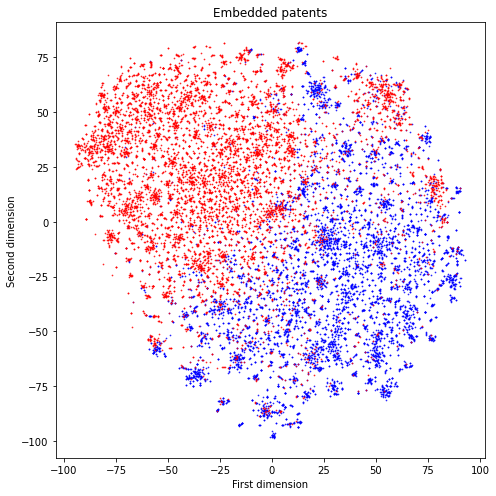

In [49]:
def plot_tsne(v, color='k', new_fig=True):
    if new_fig: plt.figure(figsize=(7, 7))
    plt.scatter(v[:, 0], v[:, 1], s=0.5, alpha=0.8, c=color)
    plt.title("Embedded patents")
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    plt.tight_layout()
    if not new_fig: plt.show()
        
num_pos = len(pos_json)
plot_tsne(v_tsne[:num_pos], color='b', new_fig=True)
plot_tsne(v_tsne[num_pos:], color='r', new_fig=False)

In [51]:
colors_path = Path('F:/datasets/PRV_KEMI_DATA/patent_colors/colored_patents.json')
with open(colors_path) as fp:
    patent_colors = json.load(fp)
color_classes = set()
for doc, doc_colors in patent_colors.items():
    color_classes.update(doc_colors.keys())
print("Available color classes are:", color_classes)

Available color classes are: {'k9', 'k12', 'k20', 'k8', 'k10'}


In [133]:
n_colors = 8
color_class = f'k{n_colors}'
def get_color(patent, color=color_class):
    patent_number = patent['document_number']
    doc_color = patent_colors[patent_number][color]
    return doc_color

pos_colors = np.array([get_color(doc) for doc in pos_json]) / (n_colors-1)
neg_colors = np.array([get_color(doc) for doc in neg_json]) / (n_colors-1)




In [134]:
colors_to_classes_path = colors_path.parent / f'colors_to_classes_k{n_colors}.json'
with open(colors_to_classes_path) as fp:
    colors_to_classes = json.load(fp)
#colors_to_classes['main_classes']

In [135]:
min_frac = 0.01  # Only keep classes which is at least this large fraction of the color
max_n = 4
colors_to_classes_filtered = {color: ', '.join([f"{ipc_class['class']}({ipc_class['fraction']:.2%})" for i, ipc_class in zip(range(max_n), ipc_classes) if ipc_class['fraction'] > min_frac]) for color, ipc_classes in colors_to_classes['main_classes'].items()}
colors_to_classes_filtered

{'0': 'B32B(14.95%), B29C(8.93%), C08L(3.93%), B41M(3.35%)',
 '1': 'C09D(27.82%), C09J(14.72%), C08G(7.33%), C09K(6.44%)',
 '2': 'H01L(13.43%), H01M(9.29%), C08L(6.38%), H04W(5.47%)',
 '3': 'G02B(9.23%), G06F(7.78%), G03F(7.08%), G01N(5.53%)',
 '4': 'C08L(5.74%), F01D(4.34%), B32B(4.03%), C08K(3.97%)',
 '5': 'A61K(30.18%), A61P(9.25%), A61B(6.02%), A61Q(4.43%)',
 '6': 'C08L(40.40%), C08K(17.85%), C08G(7.21%), C08J(6.16%)',
 '7': 'C08G(14.08%), C10N(9.01%), C10M(8.69%), C08K(8.57%)'}

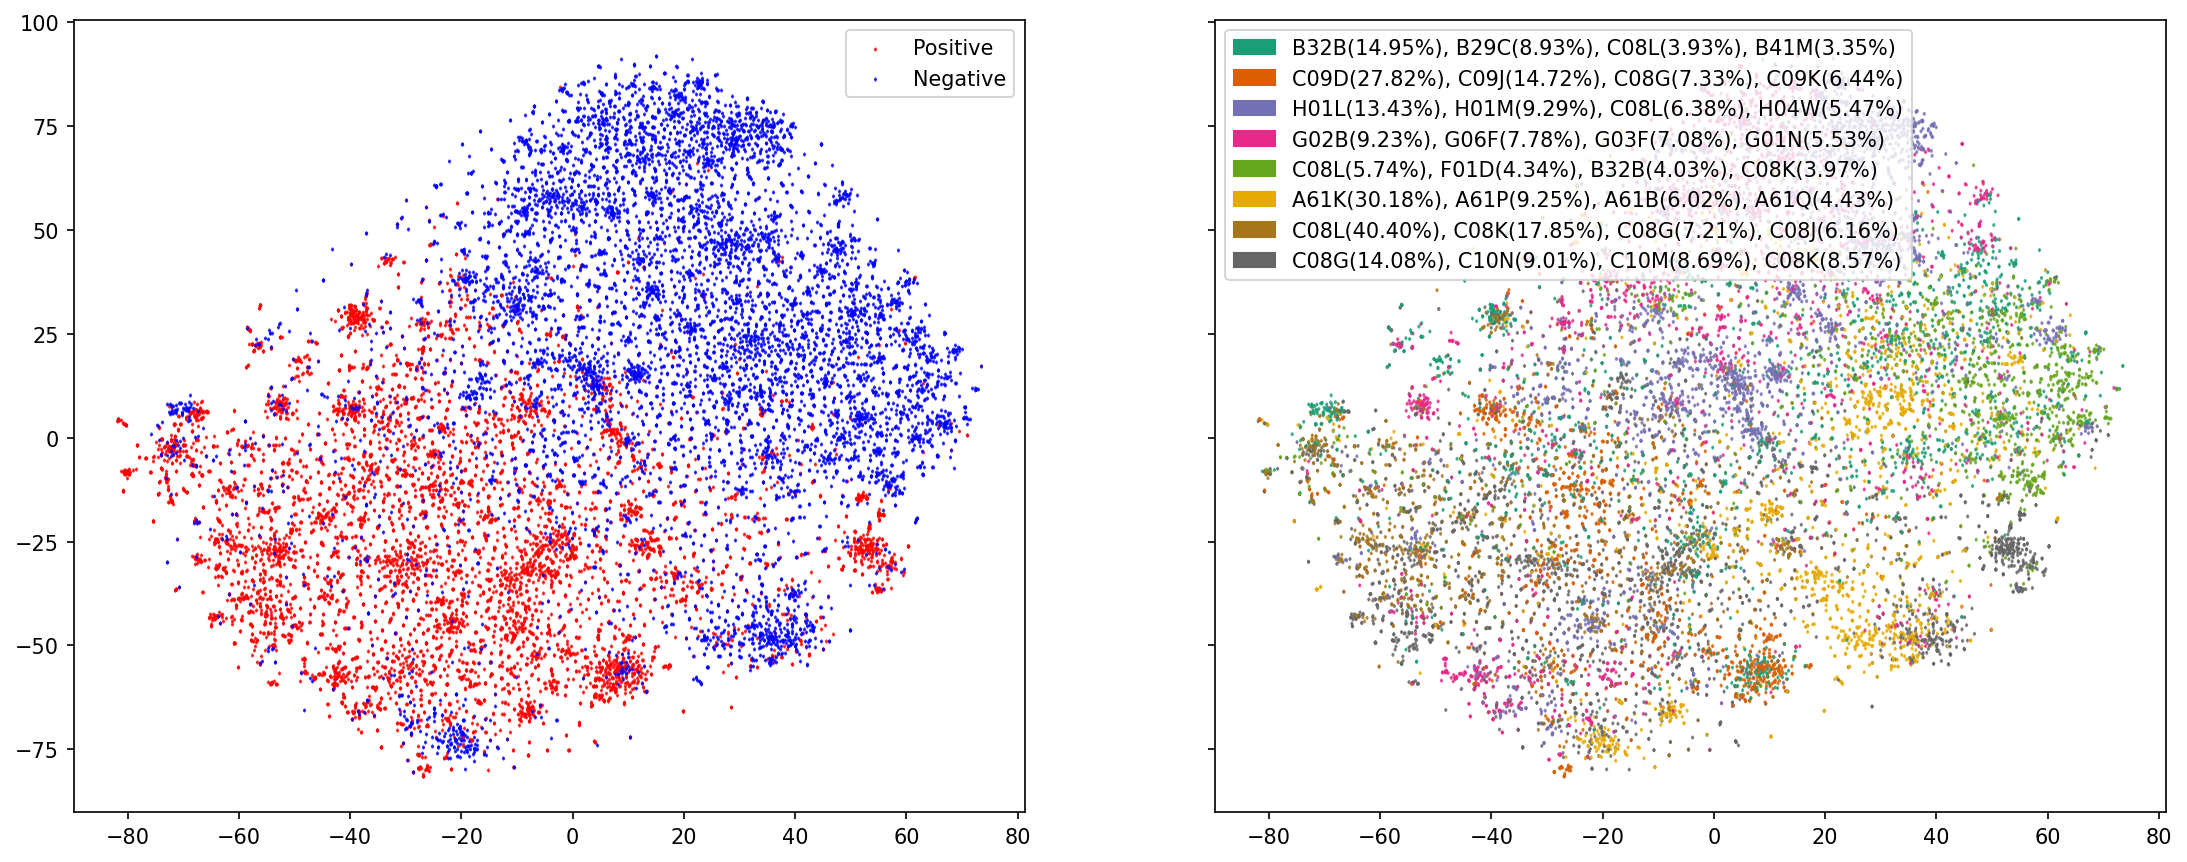

In [147]:
import matplotlib.patches as mpatches

fig, [ax1, ax2] = plt.subplots(1,2, sharex='all', sharey='all', figsize=(18,7), dpi=150)
cmap = plt.get_cmap('Dark2')
def plot_tsne(ax, v, color='k'):
    ax.scatter(v[:, 0], v[:, 1], marker='d', s=0.5, alpha=0.8, c=color, cmap=cmap)
    ax.set_title("Embedded patents")
    ax.set_xlabel("First dimension")
    ax.set_ylabel("Second dimension")
    ax.tight_layout()
    if not new_fig: plt.show()

num_pos = len(pos_json)
v_tsne_pos = v_tsne[:num_pos]
v_tsne_neg = v_tsne[num_pos:]

ax1.scatter(v_tsne_pos[:, 0], v_tsne_pos[:, 1], marker='d', s=0.5, alpha=0.8, c='red',  label='Positive')
ax1.scatter(v_tsne_neg[:, 0], v_tsne_neg[:, 1], marker='d', s=0.5, alpha=0.8, c='blue',  label='Negative')
ax1.legend()

ax2.scatter(v_tsne_pos[:, 0], v_tsne_pos[:, 1], marker='d', s=0.5, alpha=0.8, c=pos_colors, cmap=cmap)
ax2.scatter(v_tsne_neg[:, 0], v_tsne_neg[:, 1], marker='d', s=0.5, alpha=0.8, c=neg_colors, cmap=cmap)
class_proxy_artists = [mpatches.Patch(color=cmap(int(class_color)), label=classes) for class_color, classes in colors_to_classes_filtered.items()]
ax2.legend(handles=class_proxy_artists)
